In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Column, Integer, String, Float
from sqlalchemy.types import Date
from sqlalchemy.sql.expression import and_, or_, extract
import os

In [3]:
from flask import Flask, jsonify

In [4]:
pd.options.display.max_columns = 999

In [5]:
db_path = os.path.join("Resources", "hawaii.sqlite")

connection_string = f"sqlite:///{db_path}"

engine = create_engine(connection_string)

conn = engine.connect()

In [6]:
session = Session(bind=engine)

In [7]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['measurement', 'station']


In [8]:
for table_name in table_names:
    print(table_name)
    columns = inspector.get_columns(table_name)
    pprint(columns)

measurement
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]
station
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'name',
  'nullable': True,
  'primary_key': 0,
  '

In [9]:
# reflect an existing database into a new model

Base = declarative_base()

# reflect the tables
class meas(Base):
    __tablename__ = "measurement"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(Date)
    prcp = Column(Float)
    tobs = Column(Float)
    
class sta(Base):
    __tablename__ = "station"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    name = Column(String)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)

In [10]:
query = session.query(meas.date).limit(5)
pprint(query.all())

[(datetime.date(2010, 1, 1),),
 (datetime.date(2010, 1, 2),),
 (datetime.date(2010, 1, 3),),
 (datetime.date(2010, 1, 4),),
 (datetime.date(2010, 1, 6),)]


In [11]:
# Save references to each table
Station = sta
Measurement = meas

# Exploratory Climate Analysis

## Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
one_year = dt.timedelta(days=365)
max_date = session.query(func.max(meas.date)).first()[0]
start_date = max_date - one_year
start_date = start_date.isoformat()

# Perform a query to retrieve the date and precipitation scores
precip_measurements = f"SELECT m.date, m.prcp FROM measurement as m WHERE m.date >= '{start_date}';"

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(precip_measurements, conn)

# Sort the dataframe by date
df.sort_values(by="date")
df.set_index("date", inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'Inches')

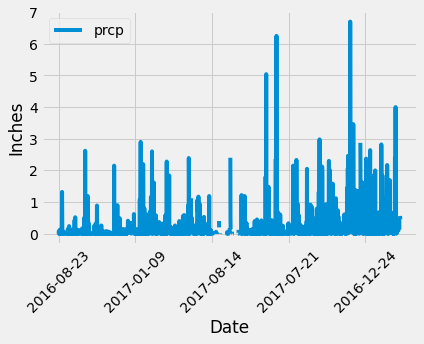

In [14]:
ax = df.plot(rot=45)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

Design a query to calculate the total number of stations.

Design a query to find the most active stations.

List the stations and observation counts in descending order.

Which station has the highest number of observations?

Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.

Design a query to retrieve the last 12 months of temperature observation data (TOBS).

Filter by the station with the highest number of observations.

Plot the results as a histogram with bins=12.

In [16]:
# Design a query to show how many stations are available in this dataset
station_count = "SELECT COUNT(DISTINCT(m.station)) FROM measurement as m"
engine.execute(station_count)
df_station_count = pd.read_sql(station_count, conn)
df_station_count

,COUNT(DISTINCT(m.station))
0,9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = """
    SELECT m.station, count(m.station) FROM measurement as m
    GROUP BY m.station
    ORDER BY count(m.station) DESC;
    """
df_active_stations = pd.read_sql(active_stations, conn)
df_active_stations

,station,count(m.station)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


## Most active station

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
most_active_station = df_active_stations["station"][0]
most_active_station

'USC00519281'

### Station USC00519281 has the highest number of observations.

In [19]:
most_active_station_stats = f"SELECT min(m.tobs), max(m.tobs), avg(m.tobs) FROM measurement as m WHERE m.station == '{most_active_station}';"
df_most_active_station_stats = pd.read_sql(most_active_station_stats, conn)
df_most_active_station_stats

,min(m.tobs),max(m.tobs),avg(m.tobs)
0,54.0,85.0,71.663781


In [20]:
temps_12months = f"SELECT m.station, m.date, m.tobs FROM measurement as m WHERE m.date >= '{start_date}';"
df_temps_12months = pd.read_sql(temps_12months, conn)
df_temps_12months

,station,date,tobs
0,USC00519397,2016-08-23,81.0
1,USC00519397,2016-08-24,79.0
2,USC00519397,2016-08-25,80.0
3,USC00519397,2016-08-26,79.0
4,USC00519397,2016-08-27,77.0
...,...,...,...
2225,USC00516128,2017-08-19,71.0
2226,USC00516128,2017-08-20,78.0
2227,USC00516128,2017-08-21,76.0
2228,USC00516128,2017-08-22,76.0


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_tobs = """SELECT m.station, count(m.tobs) FROM measurement as m
    GROUP BY m.station
    ORDER BY count(m.tobs) DESC;"""
df_most_tobs = pd.read_sql(most_tobs, conn)
station_highest_count_tobs = df_most_tobs["station"][0]

tobs_12mo = f"""SELECT m.station, m.date, m.tobs FROM measurement as m 
    WHERE m.date >= '{start_date}'
    and m.station == '{station_highest_count_tobs}'
    ;"""
df_tobs_12mo = pd.read_sql(tobs_12mo, conn)
df_tobs_12mo

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


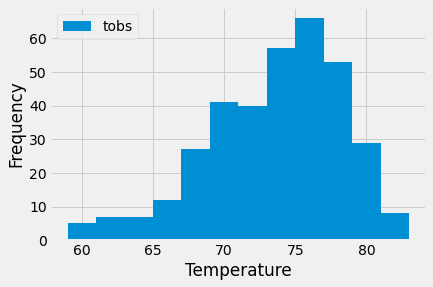

In [22]:
plt.hist(df_tobs_12mo["tobs"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper left")
plt.show()

## Bonus: Other Recommended Analyses

The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.
Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

Temperature Analysis II
The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.

Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

Plot the min, avg, and max temperature from your previous query as a bar chart.

Use the average temperature as the bar height.

Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).



Daily Rainfall Average
Calculate the rainfall per weather station using the previous year's matching dates.

Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.

Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.

Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

Use Pandas to plot an area plot (stacked=False) for the daily normals.

## Temperature Analysis I

In [23]:
avg_June_temps = "SELECT m.station, m.date as Date, m.tobs as avg_June_temps FROM measurement as m WHERE strftime('%m', Date) == '06'"
df_June_temps = pd.read_sql(avg_June_temps, conn)
df_avg_June_temps = df_June_temps.groupby(["station"]).mean()
df_avg_June_temps

,avg_June_temps
station,
USC00511918,74.139394
USC00513117,74.050847
USC00514830,76.005376
USC00516128,71.937220
USC00517948,76.655405
USC00518838,73.394737
USC00519281,73.271186
USC00519397,77.559322
USC00519523,76.668103


In [24]:
avg_Dec_temps = "SELECT m.station, m.date as Date, m.tobs as avg_Dec_temps FROM measurement as m WHERE strftime('%m', Date) == '12'"
df_Dec_temps = pd.read_sql(avg_Dec_temps, conn)
df_avg_Dec_temps = df_Dec_temps.groupby(["station"]).mean()
df_avg_Dec_temps

,avg_Dec_temps
station,
USC00511918,69.684211
USC00513117,71.069444
USC00514830,73.224719
USC00516128,69.291262
USC00517948,71.834862
USC00518838,72.421053
USC00519281,69.903226
USC00519397,71.109524
USC00519523,72.433333


In [25]:
x = list(df_avg_June_temps["avg_June_temps"] - df_avg_Dec_temps["avg_Dec_temps"])
sorted_x = sorted(x)
sorted_x

[0.973684210526315,
 2.6459575950193823,
 2.7806572429624197,
 2.981403013182671,
 3.3679606342263497,
 4.2347701149425205,
 4.455183413078146,
 4.820543020084301,
 6.449798224374504]

In [26]:
from scipy.stats import ttest_ind

ttest_ind(df_avg_June_temps["avg_June_temps"], df_avg_Dec_temps["avg_Dec_temps"])

Ttest_indResult(statistic=4.615865424404701, pvalue=0.00028626292761018595)

### The differences in average temps between June and December are relatively insignificant, ranging from 1 to 6 degrees depending on the station.
### The t-test resulted in a high t-score, indicating the datasets are more different (meaning the results are likely repeatable) and less similar and the probability is very low that the difference is a result of chance (very low p-value).
### I chose to do an unpaired t-test since there are two distinct datasets (temperatures for June and December over multiple years), rather than samples from within a single dataset.

## Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).\
        filter(meas.date >= start_date).filter(meas.date <= end_date).all()

In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Selected vacation dates: 2015-10-21 to 2015-10-28

tmin = calc_temps('2014-10-21', '2014-10-21')[0][0]
tavg = calc_temps('2014-10-21', '2014-10-21')[0][1]
tmax = calc_temps('2014-10-21', '2014-10-21')[0][2]

print("Min temp: ", tmin, "\nAvg temp: ", round(tavg, 1), "\nMax temp: ", tmax)

Min temp:  69.0 
Avg temp:  76.1 
Max temp:  81.0


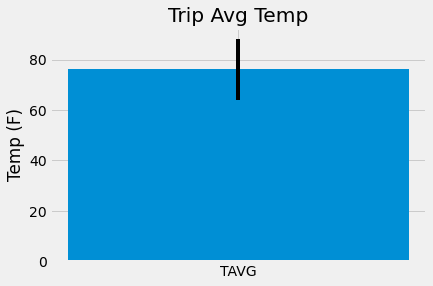

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_err = tmax-tmin
x_axis = ["TAVG"]

plt.bar(x_axis, tavg, yerr=y_err)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

## Daily Rainfall Average

In [56]:
selections = [func.sum(Measurement.prcp), Measurement.station]

result = session.query(*selections)\
.filter(func.strftime("%Y-%m-%d", Measurement.date) > "2015-10-20",\
        func.strftime("%Y-%m-%d", Measurement.date) < "2015-10-29")\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp))\
.all()

result

[(None, 'USC00517948'),
 (None, 'USC00518838'),
 (0.19, 'USC00514830'),
 (0.19, 'USC00519397'),
 (0.25, 'USC00511918'),
 (0.45, 'USC00513117'),
 (0.5900000000000001, 'USC00519281'),
 (0.66, 'USC00519523'),
 (3.1900000000000004, 'USC00516128')]

In [75]:
measurements_df = pd.DataFrame(result, columns=["prcp", "station"]).fillna(0)
measurements_df

,prcp,station
0,0.00,USC00517948
1,0.00,USC00518838
2,0.19,USC00514830
3,0.19,USC00519397
4,0.25,USC00511918
5,0.45,USC00513117
6,0.59,USC00519281
7,0.66,USC00519523
8,3.19,USC00516128


In [76]:
select = [sta.station, sta.name, sta.latitude, sta.longitude, sta.elevation]

result_2 = session.query(*select)\
.filter(func.strftime("%Y-%m-%d", Measurement.date) > "2015-10-20",\
        func.strftime("%Y-%m-%d", Measurement.date) < "2015-10-29")\
.group_by(sta.station)\
.all()

In [77]:
result_2_df = pd.DataFrame(result_2)
result_2_df

,station,name,latitude,longitude,elevation
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [80]:
Precip_DF = measurements_df.merge(result_2_df, on="station").sort_values("prcp", ascending=False)
Precip_DF

,prcp,station,name,latitude,longitude,elevation
8,3.19,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
7,0.66,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,0.59,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,0.45,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,0.25,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
2,0.19,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.19,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
0,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
1,0.00,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [132]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = "2015-10-21"
trip_end = "2015-10-28"
step = dt.timedelta(days=1)

start = dt.datetime.strptime(trip_start, "%Y-%m-%d")
end = dt.datetime.strptime(trip_end, "%Y-%m-%d")

# Use the start and end date to create a range of dates
while start <= end:
    normals.append(start.date().isoformat())
    start += step

# Strip off the year and save a list of %m-%d strings
# [dt.datetime.strptime(norm, "%m-%d") for norm in normals]
dates = [norm[5:] for norm in normals]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = [daily_normals(date) for date in dates]
daily_norms

[[(66.0, 74.96078431372548, 82.0)],
 [(66.0, 74.84313725490196, 81.0)],
 [(66.0, 75.74468085106383, 84.0)],
 [(69.0, 74.98039215686275, 81.0)],
 [(68.0, 75.0, 81.0)],
 [(68.0, 75.17307692307692, 81.0)],
 [(64.0, 75.12, 81.0)],
 [(68.0, 74.75471698113208, 82.0)]]

In [154]:
normals

['2015-10-21',
 '2015-10-22',
 '2015-10-23',
 '2015-10-24',
 '2015-10-25',
 '2015-10-26',
 '2015-10-27',
 '2015-10-28']

In [133]:
t_min = []
t_avg = []
t_max = []

for norm in daily_norms:
    t_min.append(norm[0][0])
    t_avg.append(norm[0][1])
    t_max.append(norm[0][2])

In [146]:
d = {"date": normals,
    "t_min": t_min,
    "t_avg": t_avg,
    "t_max": t_max}

daily_norms_df = pd.DataFrame(data=d)
daily_norms_df = d_norms_df.set_index(["date"])
daily_norms_df

,t_min,t_avg,t_max
date,,,
2015-10-21,66.0,74.960784,82.0
2015-10-22,66.0,74.843137,81.0
2015-10-23,66.0,75.744681,84.0
2015-10-24,69.0,74.980392,81.0
2015-10-25,68.0,75.000000,81.0
2015-10-26,68.0,75.173077,81.0
2015-10-27,64.0,75.120000,81.0
2015-10-28,68.0,74.754717,82.0


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'Temperature')

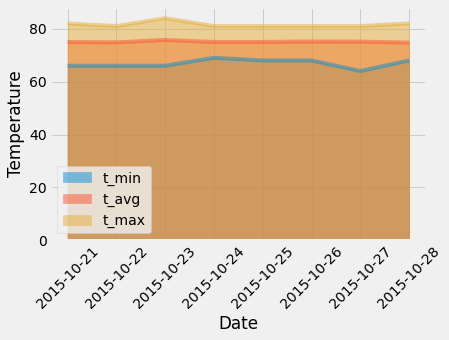

In [153]:
# Plot the daily normals as an area plot with `stacked=False`
ax_daily_norms_df = daily_norms_df.plot.area(stacked=False, rot=45)
ax_daily_norms_df.set_xlabel("Date")
ax_daily_norms_df.set_ylabel("Temperature")